In [2]:
#It's like Christmas time with all of these packages

import math
import pandas as pd
import numpy as np
from operator import itemgetter


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
#Let's read in some data with which we can work. 

INFILE = r"C:\Users\jaysa\OneDrive\Desktop\Practical Machine Learning\Assignment 4 Files\HMEQ_Loss.csv"

TARGET_B = "TARGET_BAD_FLAG" #Target_F in car insurance example
TARGET_L = "TARGET_LOSS_AMT" #Target_A in car insurance example


df = pd.read_csv( INFILE )

dt = df.dtypes
dt

TARGET_BAD_FLAG      int64
TARGET_LOSS_AMT    float64
LOAN                 int64
MORTDUE            float64
VALUE              float64
REASON              object
JOB                 object
YOJ                float64
DEROG              float64
DELINQ             float64
CLAGE              float64
NINQ               float64
CLNO               float64
DEBTINC            float64
dtype: object

In [4]:
#Scrub-a-dub-dub, let's get this data cleaned up

objList = [] # separate out the objects from the numbers
numList = []
for i in dt.index :
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64","int64"]) : numList.append( i )
        
dt = df.dtypes
objList = []
for i in dt.index :
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )

#Clean data doesn't like missing values

for i in objList :
    print( i )
    print( df[i].unique() )
    g = df.groupby( i )
    print( g[i].count() )
    print( "MOST COMMON = ", df[i].mode()[0] )   
    print( "MISSING = ", df[i].isna().sum() )
    print( "\n\n")
    
for i in objList :
    if df[i].isna().sum() == 0 : continue
    print( i ) 
    print("HAS MISSING")
    NAME = "IMP_"+i
    print( NAME ) 
    df[NAME] = df[i]
    df[NAME] = df[NAME].fillna(df[NAME].mode()[0] )
    print( "variable",i," has this many missing", df[i].isna().sum() )
    print( "variable",NAME," has this many missing", df[NAME].isna().sum() )
    g = df.groupby( NAME )
    print( g[NAME].count() )
    print( "\n\n")
    df = df.drop( i, axis=1 )
        
#Now our imputed reason and imputed job variables have no missing values. Let's rank the job tiers as a kind of corporate 
#ladder and create associated flag variables for each. In this ladder, the ProfExe is on top, followed by the Mgr, then
#Office, next Sales, Self, and finally Other.

print( df["IMP_JOB"].unique() )

df["y_IMP_JOB_6"] = (df.IMP_JOB.isin( ["ProfExe"] ) + 0 )
df["y_IMP_JOB_5"] = (df.IMP_JOB.isin( ["ProfExe","Mgr"] ) + 0)
df["y_IMP_JOB_4"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office"] ) + 0)
df["y_IMP_JOB_3"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office","Sales"] ) + 0)
df["y_IMP_JOB_2"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office","Sales","Self"] ) + 0)
df["y_IMP_JOB_1"] = (df.IMP_JOB.isin( ["ProfExe","Mgr","Office","Sales","Self","Other"] ) + 0)
df = df.drop( "IMP_JOB", axis=1 )


#We also need to rank the reasons for the HMEQ. Since we found home improvement has a lower default rate the debt
#consolidation previously, we will assign home improvement the higher rank. We need to do this for both ObjList variables
#to build our decision tree model

print( df["IMP_REASON"].unique() )

df["y_IMP_REASON_2"] = (df.IMP_REASON.isin( ["HomeImp"] ) + 0 )
df["y_IMP_REASON_1"] = (df.IMP_REASON.isin( ["HomeImp","DebtCon"] ) + 0)
df = df.drop( "IMP_REASON", axis=1 )

#Let's verify that we have no more object type variables

dt = df.dtypes
objList = []
for i in dt.index :
    print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )


for i in objList :
    thePrefix = "z_" + i
    y = pd.get_dummies( df[i], prefix=thePrefix, drop_first=True )   
    y = pd.get_dummies( df[i], prefix=thePrefix )   
    df = pd.concat( [df, y], axis=1 )
    df = df.drop( i, axis=1 )

REASON
['HomeImp' nan 'DebtCon']
REASON
DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64
MOST COMMON =  DebtCon
MISSING =  252



JOB
['Other' nan 'Office' 'Sales' 'Mgr' 'ProfExe' 'Self']
JOB
Mgr         767
Office      948
Other      2388
ProfExe    1276
Sales       109
Self        193
Name: JOB, dtype: int64
MOST COMMON =  Other
MISSING =  279



REASON
HAS MISSING
IMP_REASON
variable REASON  has this many missing 252
variable IMP_REASON  has this many missing 0
IMP_REASON
DebtCon    4180
HomeImp    1780
Name: IMP_REASON, dtype: int64



JOB
HAS MISSING
IMP_JOB
variable JOB  has this many missing 279
variable IMP_JOB  has this many missing 0
IMP_JOB
Mgr         767
Office      948
Other      2667
ProfExe    1276
Sales       109
Self        193
Name: IMP_JOB, dtype: int64



['Other' 'Office' 'Sales' 'Mgr' 'ProfExe' 'Self']
['HomeImp' 'DebtCon']
 here is i ..... TARGET_BAD_FLAG  ..... and here is the type int64
 here is i ..... TARGET_LOSS_AMT  ..... and here is the type flo

In [5]:
#Good news! No more object variables. We need to remove missing values for numList variables, too. Here, we will apply 
#the median value of the appropriate category for simplicity

for i in numList :
    if df[i].isna().sum() == 0 : continue
    IMP = "IMP_" + i
    df[ IMP ] = df[ i ]
    df.loc[ df[IMP].isna(), IMP ] = df[i].median()
    df = df.drop( i, axis=1 )
    
#And last, but not least, let's handle the outliers.

dt = df.dtypes
numList = []
for i in dt.index :
    print(i, dt[i])
    if i in ( [ TARGET_B, TARGET_L ] ) : continue
    if dt[i] in (["float64","int64"]) : numList.append( i )


for i in numList :
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theCutoff = round( theMean + 3*theSD )
    if theMax < theCutoff : continue
    FLAG = "O_" + i
    TRUNC = "TRUNC_" + i
    df[ FLAG ] = ( df[i] > theCutoff )+ 0
    df[ TRUNC ] = df[ i ]
    df.loc[ df[TRUNC] > theCutoff, TRUNC ] = theCutoff
    df = df.drop( i, axis=1 )

for i in objList:
    df = df.drop( i, axis=1 )

TARGET_BAD_FLAG int64
TARGET_LOSS_AMT float64
LOAN int64
y_IMP_JOB_6 int32
y_IMP_JOB_5 int32
y_IMP_JOB_4 int32
y_IMP_JOB_3 int32
y_IMP_JOB_2 int32
y_IMP_JOB_1 int32
y_IMP_REASON_2 int32
y_IMP_REASON_1 int32
IMP_MORTDUE float64
IMP_VALUE float64
IMP_YOJ float64
IMP_DEROG float64
IMP_DELINQ float64
IMP_CLAGE float64
IMP_NINQ float64
IMP_CLNO float64
IMP_DEBTINC float64


In [6]:
#Split the data

X = df.copy() #We are removing the target variables from X
X = X.drop( TARGET_B, axis=1 )
X = X.drop( TARGET_L, axis=1 )

Y = df[ [TARGET_B, TARGET_L] ] #And adding the target variables to Y

#This creates a training and testing data set where the train_size/test_size variables are the percentage of
#records assigned to each group. Here 80% go to the training group and 20% go to the testing group
#Assigning a random_state for the random number seed will produce repeatable split of test and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=2)

print( "FLAG DATA" )
print( "TRAINING = ", X_train.shape )  # number of records assigned, number of variables
print( "TEST = ", X_test.shape )

#Let's now separate out records of people who actually defaulted on a loan to predict the amount of loss 
#of the defaulted loans. We want to apply this to both training and test data

F = ~ Y_train[ TARGET_L ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_L ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

print( Z_train.describe() )
print( Z_test.describe() )

#We can see that the average loss on a defaulted loan is a little over $13,000 in both datasets. However, there are large
#outliers that may skew the decision tree. Let's deal with those outliers. The median loss is about $11,000 as is the
#standard deviation, so let's cap outlier amounts at $33,000

F = Z_train[ TARGET_L ] > 33000
Z_train.loc[ F, TARGET_L ] = 33000

F = Z_test[ TARGET_L ] > 33000
Z_test.loc[ F, [TARGET_L] ] = 33000

print( Z_train.describe() )
print( Z_test.describe() )

print( " ====== ")

print( "AMOUNT DATA" )
print( "TRAINING = ", W_train.shape )
print( "TEST = ", Z_test.shape )

FLAG DATA
TRAINING =  (4768, 28)
TEST =  (1192, 28)
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            941.0       941.000000
mean               1.0     13634.824655
std                0.0     10836.172568
min                1.0       224.000000
25%                1.0      5837.000000
50%                1.0     11266.000000
75%                1.0     18069.000000
max                1.0     78987.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            248.0       248.000000
mean               1.0     12578.879032
std                0.0     10833.019569
min                1.0       320.000000
25%                1.0      4921.000000
50%                1.0      9693.500000
75%                1.0     15601.250000
max                1.0     73946.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            941.0       941.000000
mean               1.0     12976.925611
std                0.0      8814.955812
min                1.0       224.000000
25%                1.0      

In [58]:
#We need to define some functions to streamline the models and neural networks we're building

def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( ROC Curve )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nDefault")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )


def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nLoss")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )
        
def get_TF_ProbAccuracyScores( NAME, MODEL, X, Y ) :
    probs = MODEL.predict( X )
    pred_list = []
    for p in probs :
        pred_list.append( np.argmax( p ) )
    pred = np.array( pred_list )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

SyntaxError: invalid syntax (<ipython-input-58-ac32897d9e3a>, line 14)

38/38 [==============================] - 0s 1ms/step


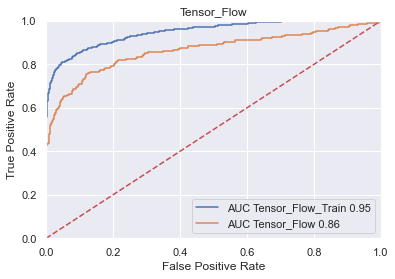

Tensor_Flow CLASSIFICATION ACCURACY
Tensor_Flow_Train  =  0.9330956375838926
Tensor_Flow  =  0.889261744966443
------




In [32]:
from sklearn.preprocessing import MinMaxScaler #This will convert X to values ranging between 0 and 1
theScaler = MinMaxScaler()
theScaler.fit( X_train )

#With our first attempt, let's build a basic neural netowrk with no frills

WHO = "Tensor_Flow"

U_train = theScaler.transform( X_train )
U_test = theScaler.transform( X_test )

U_train = pd.DataFrame( U_train ) #Converting the X variables into a new dataframe to avoid problems with arrays
U_test = pd.DataFrame( U_test )

U_train.columns = list( X_train.columns.values ) #Adding the columns names in to the U_train and U_test dataframes
U_test.columns = list( X_train.columns.values )

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.relu #Relu is the most common activation so let's use this one first
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam() #Adam is the most common optimizer. Let's use this one almost always
F_theEpochs = 250 #Number of iterations

F_theUnits = int( 2*F_theShapeSize ) #Let's start with 2 times the number of variables

#No frills means only a single layer and we'll save the dropouts for another model
F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )


CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_B], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_B ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_B ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

38/38 [==============================] - 0s 2ms/step


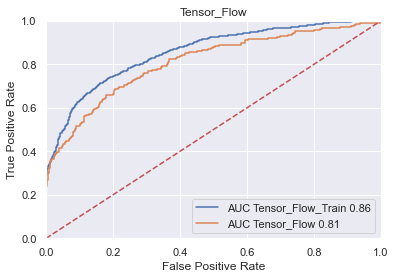

Tensor_Flow CLASSIFICATION ACCURACY
Tensor_Flow_Train  =  0.8613674496644296
Tensor_Flow  =  0.8531879194630873
------




In [14]:
#So let's start with the good news! Our accuracy for both the the training and testing data is high at 89% for the test data
#However, the training data ROC curve is quite a bit higher than the test data which suggests overfitting may be happening.
#Let's make a few changes and see if we can compensate from the overfitting problem.


WHO = "Tensor_Flow"

U_train = theScaler.transform( X_train )
U_test = theScaler.transform( X_test )

U_train = pd.DataFrame( U_train ) #Converting the X variables into a new dataframe to avoid problems with arrays
U_test = pd.DataFrame( U_test )

U_train.columns = list( X_train.columns.values ) #Adding the columns names in to the U_train and U_test dataframes
U_test.columns = list( X_train.columns.values )

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.softmax #let's give softmax a turn
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam() #Adam is the most common optimizer. Let's use this one almost always
F_theEpochs = 250 #Number of iterations

F_theUnits = int( 2*F_theShapeSize / 3 ) #Let's reduce the number of variables by dividing by three

#This time we'll add an extra hidden layer and a dropout layer to reduce the chances of overfitting
F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )


CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_DROP )
CLM.add( F_LAYER_02 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_B], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_B ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_B ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

In [42]:
#Hey! Our ROC curves are getting closer which suggests we are less likely to be overfitting. We've taken only a small hit
#to our bad loan probabilities, too. Let's try one more time, and this time we'll use variable selection to try and get
#the ROC curve even closer. Let's go grab our gradient boosting model to help us select the variables.

def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

WHO = "GB"

CLM = GradientBoostingClassifier( random_state=8 )
CLM = CLM.fit( X_train, Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_B ] )


feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )


# Predict the expected losses for a defaulted loan

AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_L] )

feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

GB_flag = []
for i in vars_GB_flag :
    print(i)
    theVar = i[0]
    GB_flag.append( theVar )
    
print("\n")

GB_amt = []
for i in vars_GB_amt :
    print(i)
    theVar = i[0]
    GB_amt.append( theVar )

('TRUNC_IMP_DEBTINC', 100)
('TRUNC_IMP_DELINQ', 28)
('TRUNC_IMP_CLAGE', 14)
('TRUNC_IMP_DEROG', 10)
('TRUNC_IMP_VALUE', 7)


('TRUNC_LOAN', 100)
('TRUNC_IMP_DEBTINC', 13)
('TRUNC_IMP_CLNO', 13)


38/38 [==============================] - 0s 2ms/step


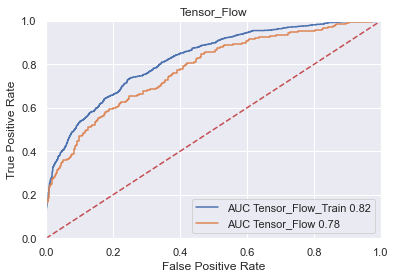

Tensor_Flow CLASSIFICATION ACCURACY
Tensor_Flow_Train  =  0.8454278523489933
Tensor_Flow  =  0.8330536912751678
------




In [51]:
#Now that we've rerun our gradient boosting model we can snag the variables that model liked for our neural network.

WHO = "Tensor_Flow"

U_train = theScaler.transform( X_train )
U_test = theScaler.transform( X_test )

U_train = pd.DataFrame( U_train ) #Converting the X variables into a new dataframe to avoid problems with arrays
U_test = pd.DataFrame( U_test )

U_train.columns = list( X_train.columns.values ) #Adding the columns names in to the U_train and U_test dataframes
U_test.columns = list( X_train.columns.values )

U_train = U_train[ GB_flag ]
U_test = U_test[ GB_flag ]

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.relu #Since softplus is similar to relu, we'll give that a turn now
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam() #Adam is the most common optimizer. Let's use this one almost always
F_theEpochs = 250 #Number of iterations

F_theUnits = int( 2*F_theShapeSize ) #Let's keep this value the same

#This time we'll add an extra hidden layer and a dropout layer to reduce the chances of overfitting
F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )


CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_DROP )
CLM.add( F_LAYER_02 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_B], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_B ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_B ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

In [35]:
#So we've reduced the difference between test and training ROC curves even further and have only taken a small hit to
#our accuracy with 83% accuracy predicting a defaulted loan. While not the most accurate in an absolute sense, I think this
#hybrid neural network taking gradient boosting variables and applying them to this model will yield the most accurate 
#results with a minimum of overfitting.So now that we've decided on a model for predicting loan defaults, let's develop
#a model that will predict expected damages based on whether the loan defaults.

#First, a basic no frills neural network

V_train = theScaler.transform( W_train ) #Convert to a 0 to 1 scale
V_test = theScaler.transform( W_test )

V_train = pd.DataFrame( V_train ) #Create a dataframe
V_test = pd.DataFrame( V_test )

V_train.columns = list( W_train.columns.values ) #Let's snag those column names, too
V_test.columns = list( W_train.columns.values )


A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.relu #We'll start with relu as the activator in this first model
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam() #Keeping it optimized with Adam
A_theEpochs = 250

A_theUnits = int( 2*A_theShapeSize  ) 

#For this first model, we will stick with a single hidden layer and leave the dropout be for now

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_L], epochs=A_theEpochs, verbose=False )


TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

8/8 [==============================] - 0s 2ms/step
Tensor_Flow RMSE ACCURACY
Tensor_Flow_Train  =  8177.351043707659
Tensor_Flow  =  8272.546456841957
------




In [39]:
#Ouch... that is not very accurate. At least the testing and training data is in sync, but that is the worst value of any
#model we've run so far to predict losses by a wide margin. Let's get to refining the model.


V_train = theScaler.transform( W_train ) #Convert to a 0 to 1 scale
V_test = theScaler.transform( W_test )

V_train = pd.DataFrame( V_train ) #Create a dataframe
V_test = pd.DataFrame( V_test )

V_train.columns = list( W_train.columns.values ) #Let's snag those column names, too
V_test.columns = list( W_train.columns.values )


A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.tanh #Variety is the spice of life. Let's use the hyperbolic tangent activation
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam() #Keeping it optimized with Adam
A_theEpochs = 500

A_theUnits = int( 2 * A_theShapeSize / 3 ) #Let's go from 2 times the variables to 2/3

#Let's drop our second hidden and dropout layers back in and see if that makes a difference

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout( 0.25 )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_L], epochs=A_theEpochs, verbose=False )


TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

8/8 [==============================] - 0s 2ms/step
Tensor_Flow RMSE ACCURACY
Tensor_Flow_Train  =  15446.125746078782
Tensor_Flow  =  14664.2846288874
------




In [52]:
#Well that's an even bigger oof. Adding layers did not seem to help us. Since utilizing the gradient boosting variables
#helped us last time, let's use them again for variable selection in this model.


V_train = theScaler.transform( W_train ) #Convert to a 0 to 1 scale
V_test = theScaler.transform( W_test )

V_train = pd.DataFrame( V_train ) #Create a dataframe
V_test = pd.DataFrame( V_test )

V_train.columns = list( W_train.columns.values ) #Let's snag those column names, too
V_test.columns = list( W_train.columns.values )

V_train = V_train[ GB_amt ] #Here we're going to be using the variable that the gradient boosting model thought was best
V_test = V_test[ GB_amt ]


A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.softplus #Let's bring it back and use softplus which is similar to relu
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam() #Keeping it optimized with Adam
A_theEpochs = 500

A_theUnits = int( 2 * A_theShapeSize  ) #Since we're bringing in only a few variables, let's keep it at 2x

#Let's keep our second hidden and dropout layers 

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout( 0.25 )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_L], epochs=A_theEpochs, verbose=False )


TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train[GB_amt], Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test[GB_amt], Z_test[TARGET_L] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_CLM = TEST_CLM.copy()
TF_AMT = TEST_AMT.copy()

8/8 [==============================] - 0s 3ms/step
Tensor_Flow RMSE ACCURACY
Tensor_Flow_Train  =  5676.358966199365
Tensor_Flow  =  5916.647631913734
------




In [48]:
#Now that's more like it. Utilizing our variables from the gradient boosting model, we've greatly improved our accuracy in
#predicting the losses from bad loans. Still not great, though. Let's import the other models really quick and then we can 
#compare the ROC curves and RMSE accuracy of every model developed.

#Logistic Regression for probability of car crash utilizing all variables

WHO = "REG_ALL"

CLM = LogisticRegression( solver='newton-cg', max_iter=500 )
CLM = CLM.fit( X_train, Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_B ] )

#Linear Regression for determining expected loss if loan defaults

AMT = LinearRegression()
AMT = AMT.fit( W_train, Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_L] )

varNames = list( X_train.columns.values )

REG_ALL_CLM = TEST_CLM.copy()
REG_ALL_AMT = TEST_AMT.copy()

#Decision tree model

def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

WHO = "TREE"

CLM = tree.DecisionTreeClassifier( max_depth=5 )
CLM = CLM.fit( X_train, Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_B ] )

feature_cols = list( X.columns.values )
tree.export_graphviz(CLM,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )
vars_tree_flag = getTreeVars( CLM, feature_cols ) 


# Predict the losses!

AMT = tree.DecisionTreeRegressor( max_depth= 5 )
AMT = AMT.fit( W_train, Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_L] )

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( AMT, feature_cols ) 


TREE_CLM = TEST_CLM.copy()
TREE_AMT = TEST_AMT.copy()

#Decision tree regression based model

WHO = "REG_TREE"

CLM = LogisticRegression( solver='newton-cg', max_iter=500 )
CLM = CLM.fit( X_train[vars_tree_flag], Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[vars_tree_flag], Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[vars_tree_flag], Y_test[ TARGET_B ] )


# Predict the losses, this time with regression!

AMT = LinearRegression()
AMT = AMT.fit( W_train[vars_tree_amt], Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[vars_tree_amt], Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[vars_tree_amt], Z_test[TARGET_L] )


varNames = list( X_train.columns.values )

REG_TREE_CLM_COEF = getCoefLogit( CLM, X_train[vars_tree_flag] )
REG_TREE_AMT_COEF = getCoefLinear( AMT, X_train[vars_tree_amt] )

REG_TREE_CLM = TEST_CLM.copy()
REG_TREE_AMT = TEST_AMT.copy()

#Random Forest model

WHO = "RF"

CLM = RandomForestClassifier( n_estimators = 25, random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_B ] )

feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( CLM, feature_cols )


# Can the random forest predict expected losses if the loan defaults?

AMT = RandomForestRegressor(n_estimators = 100, random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_L] )

feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

for i in vars_RF_amt :
    print( i )

RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()

#Regression based random forest model

WHO = "REG_RF"

RF_flag = []
for i in vars_RF_flag :
    theVar = i[0]
    RF_flag.append( theVar )

RF_amt = []
for i in vars_RF_amt :
    theVar = i[0]
    RF_amt.append( theVar )


CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[RF_flag], Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[RF_flag], Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[RF_flag], Y_test[ TARGET_B ] )

# Let's predict loan loss!

AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[RF_amt], Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[RF_amt], Z_test[TARGET_L] )

REG_RF_CLM_COEF = getCoefLogit( CLM, X_train[RF_flag] )
REG_RF_AMT_COEF = getCoefLinear( AMT, X_train[RF_amt] )

REG_RF_CLM = TEST_CLM.copy()
REG_RF_AMT = TEST_AMT.copy()

#Gradient boosting model was included earlier, but let's grab regression based gradient boosting, too

WHO = "REG_GB"


CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[GB_flag], Y_train[ TARGET_B ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[GB_flag], Y_train[ TARGET_B ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[GB_flag], Y_test[ TARGET_B ] )

#Predict the losses!

AMT = LinearRegression()
AMT = AMT.fit( W_train[GB_amt], Z_train[TARGET_L] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[GB_amt], Z_train[TARGET_L] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[GB_amt], Z_test[TARGET_L] )

REG_GB_CLM_COEF = getCoefLogit( CLM, X_train[GB_flag] )
REG_GB_AMT_COEF = getCoefLinear( AMT, X_train[GB_amt] )

REG_GB_CLM = TEST_CLM.copy()
REG_GB_AMT = TEST_AMT.copy()


Default
---------
Total Variables:  11
INTERCEPT  =  -2.934146805875108
O_LOAN  =  0.251394760224151
TRUNC_LOAN  =  -2.2627289659425808e-05
TRUNC_IMP_VALUE  =  -5.351201328193778e-07
TRUNC_IMP_DEROG  =  0.7405310457146794
O_IMP_DELINQ  =  1.76325768015024
TRUNC_IMP_DELINQ  =  0.7175876065455626
TRUNC_IMP_CLAGE  =  -0.006376630957146707
TRUNC_IMP_NINQ  =  0.18024590789053682
TRUNC_IMP_CLNO  =  -0.011386429903531179
TRUNC_IMP_DEBTINC  =  0.07108412264549066

Loss
---------
Total Variables:  10
INTERCEPT  =  -2950.624624908538
y_IMP_JOB_3  =  -62.177406871214586
y_IMP_REASON_2  =  -1772.2223867365315
TRUNC_LOAN  =  0.6068593610560526
TRUNC_IMP_VALUE  =  0.0003680212719245901
TRUNC_IMP_YOJ  =  -58.185137692980895
TRUNC_IMP_DELINQ  =  1130.6547401801245
TRUNC_IMP_CLAGE  =  -23.5755680361193
TRUNC_IMP_CLNO  =  233.7522110850853
TRUNC_IMP_DEBTINC  =  115.82970174489188
('TRUNC_LOAN', 100)
('TRUNC_IMP_DEBTINC', 11)
('TRUNC_IMP_CLNO', 11)

Default
---------
Total Variables:  11
INTERCEPT  =  -

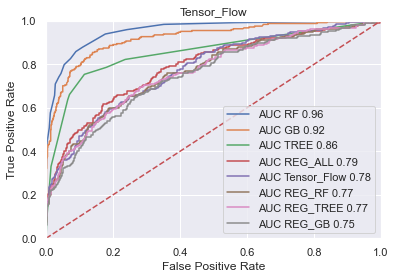

ALL CLASSIFICATION ACCURACY
RF  =  0.9085570469798657
GB  =  0.8951342281879194
TREE  =  0.8733221476510067
Tensor_Flow  =  0.8330536912751678
REG_ALL  =  0.8313758389261745
REG_TREE  =  0.8238255033557047
REG_RF  =  0.822986577181208
REG_GB  =  0.8171140939597316
------


ALL LOAN LOSS MODEL ACCURACY
GB  =  2267.978737055079
RF  =  2801.3926761930798
REG_ALL  =  4147.165955888475
REG_TREE  =  4313.296366725055
TREE  =  4802.321176938721
REG_RF  =  4973.459023628609
REG_GB  =  4973.459023628609
Tensor_Flow  =  5916.647631913734
------




In [59]:
#Let's put it all together and have each model we've developed face off head-to-head

ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM, REG_GB_CLM, TF_CLM ]

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM ) 

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )



ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, REG_GB_AMT, TF_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL LOAN LOSS MODEL ACCURACY", ALL_AMT )

In [ ]:
#So all of the models have brawled it out for supremacy.Is there a clear winner? Looking at the data, the gradient boosting
#model scores at or near the top of every category.Gradient boosting has one of the highest ROC curves behind the 
#notoriously prone to overfitting random forest. Gradient boosting also boasts the second highest classification accuracy
#and by far the best predicted loan loss. Where does this put Tensorflow? Well, we can see that Tensorflow does a good job
#with binary decisions like will a loan default or will it not. It scores in the middle of the pack for both its ROC curve
#and classification accuracy. However, things get a little less accurate when asking Tensorflow to predict a specific
#dollar amount in losses. Tensorflow was the worst performing model in this metric. All else being equal, I would stick
#with my gradient boosting model as the top overall pick, but it would probably be a good idea to verify those results
#using a neural network to support my findings using the variable selections of ther gradient boosting model.